In [48]:
from petrosianfuncs.ktau import *
#the above also imports numpy as np, pandas as pd, math, and * from petrosianfuncs.cosmology 

import matplotlib.pyplot as plt

# Functions to Test Kendall Tau
- using random samples with a lognormal distribution in z and a log-random distribution in E

## Functions

In [49]:
def rndm(a, b, g, size=1, seed=0):
    '''Power-law gen for pdf(x)\propto x^g for a<=x<=b'''
    if g >= -1:
        raise ValueError('g cannot be >= -1')
    
    g += 1
    rng = np.random.default_rng(seed)
    r = rng.random(size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

In [50]:
def recover_sample(seed=0, power=3, osize=200, pdSeries=None):
    if pdSeries is not None: #overrides all other settings
        seed = int(pdSeries['seed'])
        power = pdSeries['power']
        osize = int(pdSeries['osize'])
    
    #Generate Data
    rng = np.random.default_rng(seed)
    x = rng.lognormal(mean=-1.0, sigma=1.0, size=osize)+0.1
    #y = np.power(10, (rng.random(osize)*3+23))*g_new(x,power)*((1+x)/1.5)**power
    y = rndm(10**23, 10**26, -1.2, size=osize, seed=seed)*((1+x)/1.5)**power#*g_new(x,power)/(1.45**power)
    
    return x, y

def lowest_nonnegative(arr):
    #searching an array for first the lowest possible nonnegative k
    #then the lowest absolute magnitude negative k
    
    if (sum(arr >= 0) != 0): #if there exists a nonnegative:
        return sorted(arr[arr >= 0])[0]
    else: #only negatives
        return sorted(arr)[len(arr)-1]

def findtau0(x, y, power=3, Flim = 2.0, params=[1.5], func=E_v, g=g):
    #Clean Up Data
    ylims = func(Flim, x, *params)
    xcleans = x[np.logical_and(y > ylims, x<2.2)]
    ycleans = y[np.logical_and(y > ylims, x<2.2)]
    
    #Commence Broad Search
    ks = np.linspace(power-10,power+10,11)
    taus = np.zeros(len(ks))

    for i, k in enumerate(ks):
        taus[i] = ktau(ycleans, xcleans, Flim, func=func, g=g, k=k, params=params)
    
    zer = np.argwhere(np.diff(np.sign(taus))).flatten()
    
    if len(zer) > 1:
        print('WARNING: multiple tau=0 instances. Proceeding starting with lowest nonnegative k.')
    
    elif len(zer) == 0:
        print('WARNING: no tau=0 instances')
        if sum(taus > 0) == len(taus):
            return 999
        elif sum(taus > 0) == 0:
            return -999
        print('EXTRA WARNING: wtf this should never happen')
        return np.nan
    
    klow = lowest_nonnegative(ks[zer]) # should have tau > 0
    khigh = klow + (ks[1]-ks[0]) #klow + dk, should have tau < 0
    
    #Commence binary search in this region, assuming a monotonic function
    while (khigh-klow) > 0.01:
        mid = (khigh+klow)/2
        tau_ = ktau(ycleans, xcleans, Flim, func=func, g=g, k=mid, params=params)
        if tau_ == 0:
            return mid
        if tau_ > 0:
            klow = mid
        else:
            khigh = mid
    
    return round((khigh+klow)/2, 3)

In [51]:
def g_new(z, k): #The improved g-function, which transforms luminosities
    Z = z+1
    Z_c = 3.5
    n = 3
    return Z**k/(1+(Z/Z_c)**n)**(k/n)

In [117]:
def test_ktau(seed=0, power=3, osize=200):
    #Generate Data
    rng = np.random.default_rng(seed)
    x = rng.lognormal(mean=-1.0, sigma=1.0,size=osize)+0.1
    #y = np.power(10, (rng.random(osize)*3+23))*((1+x)/1.5)**power#*g_new(x,power)/(1.45**power)
                                             #used to be ((1+x)/2)*power, now is ((1+x)/1.5)**power
    y = rndm(10**23, 10**26, -1.2, size=osize, seed=seed)*((1+x)/1.5)**power #*g_new(x,power)/(1.45**power)
    
    #Clean Up Data
    Flim, params, func = 2.0, [1.5], E_v
    ylims = func(Flim, x, *params)
    xcleans = x[np.logical_and(y > ylims, x<2.2)]
    ycleans = y[np.logical_and(y > ylims, x<2.2)]
    
    #Best fit lines:
    mraw, braw = np.polyfit(np.log10(1+xcleans), np.log10(ycleans), 1)
    m,b=np.polyfit(np.log10(1+x[x<2.2]), np.log10(y[x<2.2]), 1)
    
    #Use Kendall Tau to calculate k:
    k = findtau0(x, y, power=power, Flim=Flim, params=params, func=func, g=g)
    
    #return true number of points, raw slope, true slope, k
    return len(xcleans), mraw, m, k

## Simulate

In [118]:
seeds = [1, 2, 3, 4, 5]
powers = [2]
sizes = [100, 200, 500, 1000, 2000, 5000]

length = len(seeds)*len(powers)*len(sizes)
i=0

info = []

for seed in seeds:
    for power in powers:
        for size in sizes:
            tseed = int(power*100000) + seed #update, use different seed for different power
            tsize, mraw, m, k = test_ktau(seed=tseed, power=power, osize=size)
            info.append(np.array([tseed, power, size, tsize, mraw, m, k]))
            print(f'DONE WITH {i+1}/{length}')
            i += 1
            
df = pd.DataFrame(data = np.stack(info), columns = ['seed', 'power', 'osize', 'tsize', 'mraw', 'm', 'k'])
print('****************DONE****************')

DONE WITH 1/30
DONE WITH 2/30
DONE WITH 3/30
DONE WITH 4/30
DONE WITH 5/30
DONE WITH 6/30
DONE WITH 7/30
DONE WITH 8/30
DONE WITH 9/30
DONE WITH 10/30
DONE WITH 11/30
DONE WITH 12/30
DONE WITH 13/30
DONE WITH 14/30
DONE WITH 15/30
DONE WITH 16/30
DONE WITH 17/30
DONE WITH 18/30
DONE WITH 19/30
DONE WITH 20/30
DONE WITH 21/30
DONE WITH 22/30
DONE WITH 23/30
DONE WITH 24/30
DONE WITH 25/30
DONE WITH 26/30
DONE WITH 27/30
DONE WITH 28/30
DONE WITH 29/30
DONE WITH 30/30
****************DONE****************


In [119]:
df.iloc[14:15]

,seed,power,osize,tsize,mraw,m,k
14,200003.0,2.0,500.0,239.0,4.618925,2.096456,2.488


In [120]:
columns = ['seed', 'power', 'osize', 'tsize', 'mraw', 'm', 'k']
dtypes  = {'seed':'int', 'power':'float', 'osize':'int', 'tsize':'int', 'mraw':'float', 'm':'float', 'k':'float'}

df = df.astype(dtypes)
df.dtypes

seed       int64
power    float64
osize      int64
tsize      int64
mraw     float64
m        float64
k        float64
dtype: object

## Display Results

In [121]:
#df[df['osize'] == 100]

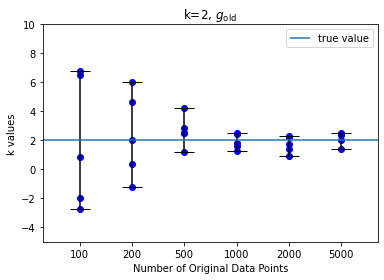

In [123]:
fig, ax = plt.subplots()

power = 2
osizes = [100, 200, 500, 1000, 2000, 5000]

for i, osize in enumerate(osizes):
    seeds = (df['power'] == power) & (df['osize'] == osize)
    ks = np.array(df[seeds]['k'])
    max_, med, min_ = max(ks), np.median(ks), min(ks)
    plt.bar(i, med, yerr=[[med-min_], [max_-med]], width=0, ecolor='black', capsize=10)
    for j in range(len(ks)):
        plt.scatter(i, ks[j], color='blue')
    #plt.scatter(i, med, color='blue', label = 'median' if i == 0 else None)

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['100', '200', '500', '1000', '2000', '5000'])
plt.ylim([-5,10])
plt.xlim([-0.7, 5.7])

gstatus = 'old'

plt.title(f'k={power}, ' + '$g_{\\mathrm{'+ gstatus + '}}$')
plt.xlabel('Number of Original Data Points')
plt.ylabel('k values')
plt.hlines(power, -0.7, 5.7, label='true value')
plt.legend()
#plt.savefig(f'../../k={power}_{gstatus}g.png', dpi=600)
plt.show()

## #1: How many k values obtained by Kendall Tau are greater than raw fit?

In [101]:
df[(df['k'] > df['mraw'])]

,seed,power,osize,tsize,mraw,m,k
5,400001,4.0,200,131,6.126532,4.119526,8.324
9,500001,5.0,200,126,5.851202,4.745958,8.918
11,500001,5.0,1000,614,5.422775,4.397353,6.105
14,300002,3.0,500,314,5.007627,2.849512,5.145
22,500002,5.0,500,303,5.016010,3.975695,5.145
25,300003,3.0,200,118,4.907529,3.428352,5.488
28,400003,4.0,100,53,5.497070,4.172871,6.895
29,400003,4.0,200,122,5.849183,4.647248,6.301
32,500003,5.0,100,53,5.307996,4.661634,7.871
37,300004,3.0,200,120,4.129980,3.033301,4.746


In [102]:
print('fraction of samples with k (kendall tau) > m (raw fit)')
for i in [100,200, 500, 1000]:
    a = len(df[(df['k'] > df['mraw']) & (df['osize'] == i)])
    b = len(df[df['osize'] == i])
    print(f'sample size {i}: {a}/{b}')

fraction of samples with k (kendall tau) > m (raw fit)
sample size 100: 11/30
sample size 200: 10/30
sample size 500: 5/30
sample size 1000: 4/30


## #2: Assuming a lower fluence threshold, when does the result become unacceptable?

In [12]:
#the task implicitly assumes that the result WAS acceptable prior to fluence threshold messup.
#otherwise, can't differentiate effects of messup. was it already messed up or is it the fluence threshold?
df[np.abs(df['k']-power) < 0.5]

,seed,power,osize,tsize,mraw,m,k
1,100001,1.0,200,115,3.369934,0.613447,0.801
6,100002,1.0,500,276,3.922099,0.579540,1.199
7,100002,1.0,1000,550,3.569381,0.857501,1.191
9,100003,1.0,200,113,4.412233,1.233054,0.754
10,100003,1.0,500,296,3.838812,1.192370,0.988
11,100003,1.0,1000,556,4.035475,0.673378,1.363
18,100005,1.0,500,270,3.979253,0.658652,1.113
22,100006,1.0,500,281,3.251320,0.750009,1.074
26,100007,1.0,500,264,3.636191,0.786024,0.777
27,100007,1.0,1000,545,3.677204,0.696172,1.207


### Test one sample first

In [43]:
x, y = recover_sample(pdSeries=df.iloc[1])
#suppose that the survey had a true, definitive cutoff of 2 Jy ms:
ylims = E_v(2.0, x, *[1.5])
x = x[y > ylims]
y = y[y > ylims]

Text(0.5, 0, 'z')

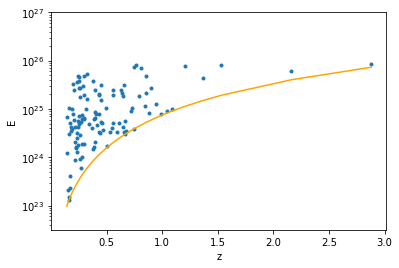

In [44]:
plt.scatter(x, y, marker='.')
plt.plot(np.sort(x), E_v(2, np.sort(x), *[1.5]), color='orange')
plt.ylim([10**22.5, 1e27])
#plt.xlim([0,2.2])
plt.yscale('log')
plt.ylabel('E')
plt.xlabel('z')

In [45]:
Flims = np.linspace(0, 4, 11)
ks = np.zeros(len(Flims))

for i, Flim in enumerate(Flims):
    ks[i] = findtau0(x, y, power=power, Flim=Flim)

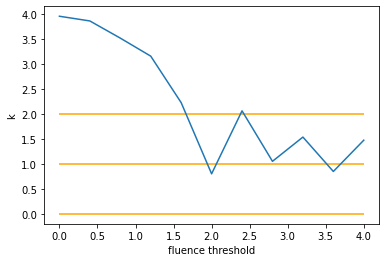

In [46]:
plt.plot(Flims, ks)
#plt.xscale('log')
plt.hlines([power-1, power, power+1], 0, 4, color='orange')
plt.xlabel('fluence threshold')
plt.ylabel('k')
plt.show()

## Run the code for multiple samples

In [47]:
#run for all samples of size {size}
allks = []
size = 100

for i in df[df['osize'] == size].index:
    x, y = recover_sample(pdSeries=df.iloc[i])
    #suppose that the survey had a true, definitive cutoff of 2 Jy ms:
    ylims = E_v(2.0, x, *[1.5])
    x = x[y > ylims]
    y = y[y > ylims]
    
    Flims = np.linspace(0, 4, 11)
    ks = np.zeros(len(Flims))

    for j, Flim in enumerate(Flims):
        ks[j] = findtau0(x, y, power=power, Flim=Flim)
    
    allks.append(ks)
    print(f'{i}/36 is done')

0/36 is done
4/36 is done
8/36 is done
12/36 is done
16/36 is done
20/36 is done
24/36 is done


/Users/williamhuang/software/python/petrosianfuncs/ktau.py:25: RuntimeWarning: invalid value encountered in reciprocal
  return (1+z)**k


28/36 is done
32/36 is done
36/36 is done


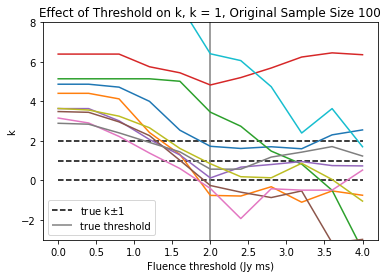

In [48]:
Flims = np.linspace(0, 4, 11)
for i in range(len(allks)):
    plt.plot(Flims, allks[i])
plt.hlines([power-1,power,power+1], 0, 4, color='black', linestyle='--', label='true k$\\pm 1$')
plt.vlines(2.0, power-4, power+7, color='gray', label='true threshold')
plt.title(f'Effect of Threshold on k, k = {power}, Original Sample Size {size}')
plt.xlabel('Fluence threshold (Jy ms)')
plt.ylabel('k')
plt.ylim([power-4,power+7])
plt.legend()
#plt.savefig(f'../../k={power}_osize={size}.png', dpi=600)
plt.show()

# #3: Determine z, E distributions

## z distributions

In [14]:
df[df['osize'] == 1000]

,seed,power,osize,tsize,mraw,m,k
3,300001,3.0,1000,434,5.200179,3.089352,3.238
7,300002,3.0,1000,488,5.352938,3.020152,1.934
11,300003,3.0,1000,458,5.281497,3.313914,2.887
15,300004,3.0,1000,461,5.218821,2.481454,3.746
19,300005,3.0,1000,429,5.720476,3.465134,3.238
23,300006,3.0,1000,478,4.936587,3.033719,0.871
27,300007,3.0,1000,452,5.357363,3.213464,3.230
31,300008,3.0,1000,472,4.958127,3.059100,3.129
35,300009,3.0,1000,457,5.216666,3.255309,2.410
39,300010,3.0,1000,481,5.339999,3.205103,3.434


In [15]:
df[abs((df['k']-power))<0.3]

,seed,power,osize,tsize,mraw,m,k
3,300001,3.0,1000,434,5.200179,3.089352,3.238
8,300003,3.0,100,46,4.942765,2.630484,2.902
11,300003,3.0,1000,458,5.281497,3.313914,2.887
19,300005,3.0,1000,429,5.720476,3.465134,3.238
24,300007,3.0,100,44,5.726703,4.757797,3.168
27,300007,3.0,1000,452,5.357363,3.213464,3.230
29,300008,3.0,200,101,4.756104,3.068425,2.988
30,300008,3.0,500,235,4.753593,2.767340,3.121
31,300008,3.0,1000,472,4.958127,3.059100,3.129


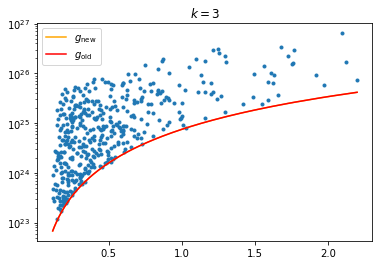

In [46]:
x, y = recover_sample(pdSeries=df.iloc[3])
#suppose that the survey had a true, definitive cutoff of 2 Jy ms:
ylims = E_v(2.0, x, *[1.5])
k=0
plt.plot(sorted(x[x<2.2]),sorted(ylims[x<2.2])/g_new(np.sort(x[x<2.2]), k), color='orange', label='$g_{\\mathrm{new}}$')
plt.plot(sorted(x[x<2.2]),sorted(ylims[x<2.2])/g(np.sort(x[x<2.2]), k), color='red', label='$g_{\\mathrm{old}}$')
#plt.scatter(x[x<2.2], y[x<2.2]/g(x[x<2.2], 4), marker='.')
x = x[y > ylims]
y = y[y > ylims]
y = y[x < 2.2]
x = x[x < 2.2]

plt.title('$k=3$')
plt.scatter(x,y/g(x,k), marker='.')
plt.yscale('log')
plt.legend()
#plt.savefig('../../difference_k=7.png', dpi=600)

In [33]:
# x, y = recover_sample(power=3,seed=300004,osize=1000)
# ylims = E_v(2.0, x, *[1.5])
# x = x[y > ylims]
# y = y[y > ylims]
# y = y[x < 2.2]
# x = x[x < 2.2]

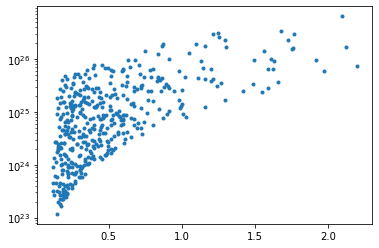

In [34]:
plt.scatter(x,y, marker='.')
plt.yscale('log')

In [35]:
k = findtau0(x,y,power=3, Flim=2.0)
print(k)

3.238


In [36]:
x_, y_ = sort_by_first(x, y)
sigmas, zs = sigma_z(y_, x_, 2.0, k=k)

In [37]:
from scipy.special import erf
def logerf(x, mu, sigma, b):
    return 0.5*(1+erf((np.log(x-b)-mu)/(sigma*2**0.5)))

def lognorm(x, mu, sigma, b):
    return (1/(x*sigma*(2*np.pi)**0.5))*np.exp(-np.power((np.log(x-b)-mu), 2)/(2*sigma**2))

In [38]:
def lerf(x, mu, sigma, C):
    return C*logerf(x, mu, sigma, 0.1)

def lnorm(x, mu, sigma, C):
    return C*lognorm(x, mu, sigma, 0.1)

import scipy.optimize as opt

guess = [-1.0, 1.0, 500]
bounds = [[-3, 0, 0], [1, 4, 10000]]

In [39]:
print('starting fitting')
optsig, pcov = opt.curve_fit(lerf, zs, sigmas, guess, bounds=bounds) 
print('done')
print(optsig)

starting fitting
done
[ -0.97951173   1.01007668 723.35230973]


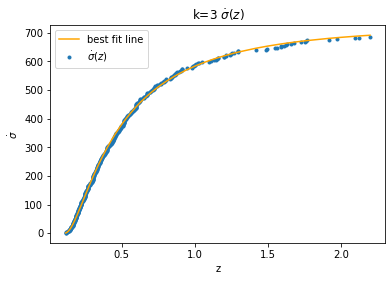

In [40]:
plt.scatter(zs, sigmas, marker='.', label='$\\dot{\\sigma}(z)$')
plt.plot(zs, lerf(zs, *optsig), color='orange', label='best fit line')
plt.legend()
plt.title(f'k={power} ' + '$\\dot{\\sigma}(z)$')
plt.ylabel('$\\dot{\\sigma}$')
plt.xlabel('z')
#plt.savefig(f'../../k={power}_dotsigma.png', dpi=600)
plt.show()

Text(0.5, 0, 'z')

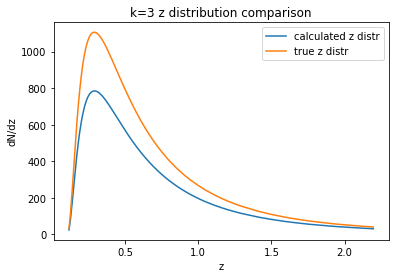

In [41]:
plt.plot(zs, lnorm(zs, *optsig), label='calculated z distr')
plt.plot(zs, 1000*lognorm(zs, -1, 1, 0.1), label='true z distr')
plt.legend()
plt.title(f'k={power} z distribution comparison')
plt.ylabel('dN/dz')
plt.xlabel('z')
#plt.savefig(f'../../k={power}_zdistr.png', dpi=600)

## E distributions

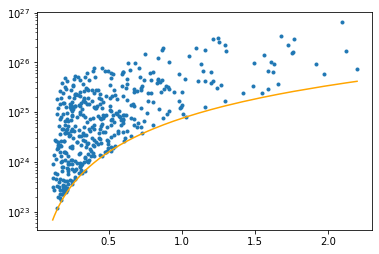

In [42]:
plt.scatter(x, y, marker='.')
plt.plot(np.sort(x), E_v(2.0, np.sort(x), *[1.5]), color='orange')
plt.yscale('log')

In [43]:
phi, E_, E_raw_k = phi_E(y, x, 2.0, func=z_E, k=3, g=g)

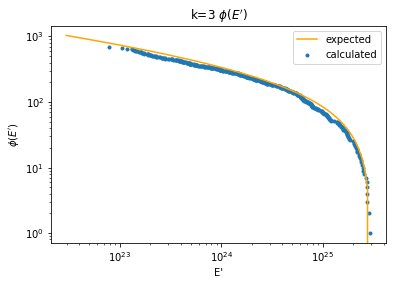

In [47]:
plt.scatter(E_, phi, marker='.', label='calculated')
xx = np.logspace(23, 26, 100)
yy = 5.5e8*(np.power(xx, -0.2)- (1e26)**(-0.2))*0.1
plt.plot(xx/(1.5)**3,yy,color='orange', label='expected')

plt.ylabel('$\\phi(E\')$')
plt.xlabel('E\'')
plt.xscale('log')
plt.title(f'k={power} $\\phi(E\')$')
plt.yscale('log')
plt.legend()
#plt.savefig(f'../../k={power}_phiE.png', dpi=600)

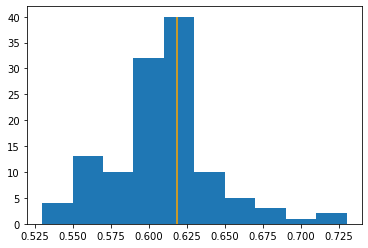

In [183]:
plt.hist(df['tsize']/df['osize'])
plt.vlines(0.6186440677966102, 0, 40, color='orange')